In [1]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import pyrealsense2 as rs
import numpy as np
from vision.classification_model import ClassificationModel
from vision.segmentation_model import SegmentationModel
# from vision.vision_models import SegmentationModel, ClassificationModel
import keras
import matplotlib.pyplot as plt
import time
import math

In [2]:
IMG_SIZE = "img_size"
BATCH_SIZE = "batch_size"
OPTIMIZER = "optimizer"
EPOCHS = "epochs"
LOSS = "loss"
METRICS = "metrics"
LEARNING_RATE = "learning_rate"
PATIENCE = "patience"
CALLBACKS = "callbacks"
PATH = "path"

### TODO:

- Combine into pipeline
- time steps
- Test camera depth 

### Questions:
- 3D integration(depth map)
- best method for pickup location (3d edge)

#### Guus vision Notes

- Segmentation results -> rectangle fit
- get edges -> diagonals
- go to nearest edge -> closest top

# Segmentation Model

This model is responsible for extracting crate front segments out of the picture of the entire carrier. These crops are then saved and forwarded to the classification model, as well as used for the pickup-point calculation.

In [14]:
segment_model = SegmentationModel()

In [17]:
seg_params = {
    PATH: "./vision/data/no-bars_no-classes_v2/data.yaml",
    IMG_SIZE: 640,
    OPTIMIZER: "AdamW",
    LEARNING_RATE: 0.0015,
    EPOCHS: 80,
    BATCH_SIZE: 8,
    PATIENCE: 10
}

In [13]:
#load previously trained model
segment_model.load_model()

In [18]:
#train model
segment_model.train(seg_params)

Ultralytics YOLOv8.0.227 🚀 Python-3.10.11 torch-2.1.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
engine\trainer: task=segment, mode=train, model=vision/yolov8s-seg.pt, data=./vision/data/no-bars_no-classes/data.yaml/data.yaml, epochs=80, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=True, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

RuntimeError: Dataset 'vision/data/no-bars_no-classes/data.yaml/data.yaml' error  './vision/data/no-bars_no-classes/data.yaml/data.yaml' does not exist

In [ ]:
#evaluate model
segment_model.test()

In [ ]:
#try model out on image(s)
results = segment_model.predict(seg_params[PATH]+"/test/images")

# Classification Model
This model is used to take cropped images of crate fronts and classify them by their pickup method. These classifications will then be combined to determine pickup point

In [17]:
class_model = ClassificationModel()

In [ ]:
learning_rate = 0.001
weight_decay = 0.004
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
params = {
    IMG_SIZE: (640,640),
    BATCH_SIZE: 16,
    OPTIMIZER: keras.optimizers.AdamW(learning_rate,weight_decay),
    LOSS: keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    METRICS: ["accuracy"],
    EPOCHS: 20,
    CALLBACKS: [callback]
}

In [ ]:
#load previous model
class_model.load_model()

In [ ]:
#train model
class_model.train(params, show=True)

In [ ]:
#evaluate model
class_model.test()

In [ ]:
#test model on new image
class_model.predict(1) #TODO: update

# Complete Pipeline

### Connect to camera

### Load models

In [2]:
from keras import backend as K

K.clear_session()

In [3]:
sm = SegmentationModel()
sm.load_model()

In [4]:
cm = ClassificationModel()
cm.load_model()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 640, 640, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 640, 640, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 640, 640, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 320, 320, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 320, 320, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 160, 160, 32)      0         
 g2D)                                                

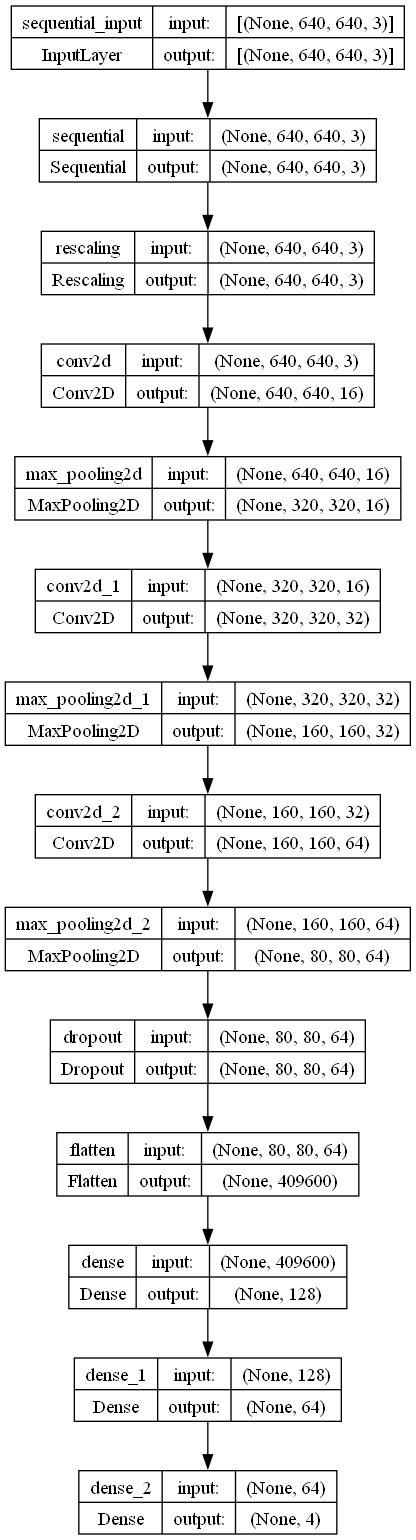

In [6]:
keras.utils.plot_model(cm.model,
                       "model.png",
                       show_shapes=True)

### Combine stream

In [15]:
def init_camera_streams():
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()

    config.enable_stream(rs.stream.depth)
    config.enable_stream(rs.stream.color)

    # Start streaming
    pipeline.start(config)
    sensor = pipeline.get_active_profile().get_device().query_sensors()[1]

    # Set the exposure anytime during the operation
    sensor.set_option(rs.option.exposure, 500.000)
    #sensor.set_option(rs.option.laser_power, 180)
    align_to = rs.stream.color
    align = rs.align(align_to)

    font = ImageFont.truetype("vision/data/Arial.ttf", 20)
    filters = [rs.spatial_filter(),rs.temporal_filter()]
    return pipeline, align, filters, font

def get_frames(pipeline, align, filters):
    # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    depth_frame = aligned_frames.get_depth_frame()
    for filter in filters:
        depth_frame = filter.process(depth_frame)
    depth_frame = depth_frame.as_depth_frame()
    color_frame = aligned_frames.get_color_frame()

    color_intrin = color_frame.profile.as_video_stream_profile().intrinsics
    k = np.array(((color_intrin.fx, 0, color_intrin.ppx),
            (0,color_intrin.fy, color_intrin.ppy),
            (0,0,1)))
    d = np.array(color_intrin.coeffs)
    return color_frame, depth_frame, k, d, color_intrin

def get_valid_neighbors(coords,limits,size):
    neighbours = []
    for i in range(-size,size+1):
        for j in range(-size,size+1):
            xn, yn = coords[0]+i, coords[1]+j
            if (xn,yn) != coords:
                if 0 <= xn < limits[0] and 0 <= yn < limits[1]:
                    neighbours.append((xn,yn))
    return neighbours

def get_2d_points(mask_raw, limits, c1):
    polygon = mask_raw.xy[0]
    epsilon = 0.1 * cv2.arcLength(polygon, True)
    box = cv2.approxPolyDP(polygon, epsilon, True)
    if box.shape != (4,1,2):
        return
    box = box.reshape(4,2)
    #rect = cv2.minAreaRect(polygon)
    #box = cv2.boxPoints(rect)
    sorted_box = box[np.argsort(box[:, 0])]
    top_points = [tuple(sorted_box[0]),tuple(sorted_box[1])]
    c1.polygon(box,outline=(0,255,0),width=5)
    c1.line(top_points,fill=(255,255,0),width=5)

    top_x, top_y = np.mean(top_points, axis=0).astype(int)
    center_x, center_y = np.mean(box,axis=0).astype(int)
    
    rel_2d_points = list(sorted_box.copy())
    rel_2d_points.append([top_x,top_y])
    rel_2d_points.append([center_x,center_y])

    r = 5
    for i, (x,y) in enumerate(rel_2d_points):
        x = int(np.clip(x, 0, limits[0]-1))
        y = int(np.clip(y, 0, limits[1]-1))
        rel_2d_points[i] = [x,y]
        c1.ellipse([(x-r,y-r),(x+r,y+r)],fill=(0,0,255))
        
    return rel_2d_points

def get_camera_3d_points(depth_frame, rel_2d_points, color_intrin, limits, depth_draw):
    rel_3d_points = []
    for x_2d,y_2d in rel_2d_points:
        depth = depth_frame.get_distance(x_2d,y_2d)
        if depth == 0:
            neighbours = get_valid_neighbors((x_2d,y_2d),(limits[0],limits[1]),1)
            distances = []
            for nx, ny in neighbours:
                depth = depth_frame.get_distance(nx, ny)
                if depth != 0:
                    distances.append(depth)
            
            if distances:
                depth = np.median(distances)
            else:
                depth = 0
                print(0)
                r=5
                depth_draw.ellipse([(x_2d-r,y_2d-r),(x_2d+r,y_2d+r)],fill=(0,255,255))

        #right: x, down: y, forward: z
        result = rs.rs2_deproject_pixel_to_point(color_intrin, [x_2d, y_2d], depth)
        """
        Camera:     Robot:
        x: down     x: left
        y: left     y: back
        z: forward  z: up

        Robot = Camera:
        x -> y
        y -> -z
        z -> -x
        """
        x_cam,y_cam,z_cam = result
        x_rob = y_cam
        y_rob = -z_cam
        z_rob = -x_cam

        rel_3d_points.append([x_rob,y_rob,z_rob])
    return rel_3d_points

def draw_angle_lines(rel_3d_points,rot,trans,k,d,c1):
    line1_points = [tuple(rel_3d_points[0]),tuple(rel_3d_points[1])]
    line2_points = [tuple(rel_3d_points[0]),tuple(rel_3d_points[2])]
    line1_vec = np.array(line1_points[1]) - np.array(line1_points[0])
    line2_vec = np.array(line2_points[1]) - np.array(line2_points[0])
    normal_vector = np.cross(line1_vec, line2_vec)
    normal_vector_unit = normal_vector / np.linalg.norm(normal_vector)
    point_on_vector = normal_vector_unit * 0.1
    line3_points = [tuple(rel_3d_points[0]),tuple(point_on_vector)]
    points = line1_points + line2_points + line3_points

    displayed_points = []
    for point in points:
        point_2d, jacobian = cv2.projectPoints(np.array(point), rot, trans, k, d)
        displayed_points.append(tuple(point_2d.flatten()))
    
    tuples_list = [(displayed_points[i], displayed_points[i + 1]) for i in range(0, len(displayed_points) - 1, 2)]
    
    for points in tuples_list:
        c1.line(points,fill=(255,255,255),width=5)

def show_3d_points(points_3d, rot, trans, k, d, c1):
    for point_3d in points_3d:
        point_3d = np.array(point_3d,dtype=np.float64)
        point_2d, jacobian = cv2.projectPoints(point_3d, rot, trans, k, d)
        x,y = tuple(point_2d.flatten())
        r=5
        c1.ellipse([(x-r,y-r),(x+r,y+r)],fill=(0,255,255))


def calculate_rotational_angles(plane_coordinates):
    # Extracting the coordinates of the plane
    p1, p2, p3, p4 = plane_coordinates

    # Calculate vectors along two edges of the plane
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)

    # Calculate the cross product to get the normal vector of the plane
    normal_vector = np.cross(v1, v2)
    # Normalize the normal vector
    normal_vector /= np.linalg.norm(normal_vector)

    # Calculate angles around x, y, and z axes (Euler angles)
    x_angle = np.arctan2(normal_vector[2], normal_vector[1])
    y_angle = np.arctan2(-normal_vector[0], np.sqrt(normal_vector[1]**2 + normal_vector[2]**2))
    z_angle = np.arctan2(v2[0], v1[0])

    # Convert angles from radians to degrees
    x_angle_deg = np.degrees(x_angle)
    y_angle_deg = np.degrees(y_angle)
    z_angle_deg = np.degrees(z_angle)

    return x_angle_deg, y_angle_deg, z_angle_deg

def get_robot_coords(camera_coords):
    R = np.array([[    0.88944,     0.45694,  -0.0094595],
    [   -0.12844,     0.26977,     0.95432],
    [    0.43862,     -0.8476,     0.29864]])
    t = np.array([    0.66218,    0.028405,     -1.7851])
    new_coords = np.dot(R,camera_coords) + t

    return new_coords

In [16]:
pipeline, align, filters, font = init_camera_streams()
try:
    while True:
        color_frame, depth_frame, k, d, color_intrin = get_frames(pipeline, align, filters)
        if not depth_frame or not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())
        img_color = Image.fromarray(color_image)
        img_color.save("input_color.jpg")

        results = sm.predict(color_image,False,True)
        #classes, conf_list = cm.predict("vision/crops/predict/crops/Crate")
        data_image = Image.open("vision/crops/monkey/predict/image0.jpg") #seg prediction results
        color_draw = ImageDraw.Draw(data_image)
        depth_image = np.asanyarray(depth_frame.get_data())
        min_depth = 850  # Minimum depth value
        max_depth = 1700  # Maximum depth value
        depth_image_clipped = np.clip(depth_image, min_depth, max_depth)
        normalized_depth = (depth_image_clipped - min_depth) / (max_depth - min_depth)
        depth_colormap = cv2.applyColorMap((normalized_depth * 255).astype(np.uint8), cv2.COLORMAP_JET)
        cv2.imwrite("depth.jpg", depth_colormap)

        masks = results[0].masks
        #for mask_raw, label in zip(masks,classes): #do classification result interpretation
        for mask_raw in masks:
            rel_2d_points = get_2d_points(mask_raw, data_image.size, color_draw)
            if not rel_2d_points:
                print("Box has incorrect shape -> no crate")
                continue
            rel_3d_points = get_camera_3d_points(depth_frame, rel_2d_points, color_intrin,data_image.size, color_draw)
            success, rot, trans = cv2.solvePnP(np.array(rel_3d_points).astype("float32"),np.array(rel_2d_points).astype("float32"),k,d)
            
            show_3d_points(rel_3d_points[:4],rot, trans, k, d, color_draw)
            #draw_angle_lines(rel_3d_points,rot,trans,k,d,color_draw)

            robot_coords = []
            for coord in rel_3d_points[:4]:
                rob_coord = get_robot_coords(coord)
                robot_coords.append(rob_coord)
            
            x,y,z = get_robot_coords(rel_3d_points[4])
            rx,ry,rz = calculate_rotational_angles(robot_coords)
            point = tuple(round(c,1) for c in (x,y,z,rx,ry,rz))
            print(point)
            color_draw.text(rel_2d_points[4], f"{x,y,z,rx,ry,rz}", fill=(255,255,255), font=font)
            
        data_image.show()
        data_image.save("distance_annot.jpg")
        break
except Exception as e:
    print(e)
    pass
finally:
    pipeline.stop()


0: 384x640 3 Crates, 194.0ms
Speed: 0.0ms preprocess, 194.0ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to vision\crops\monkey\predict
-0.056030649862855775 -0.7922935978883505 -0.9799868945232034 -78.15 -19.42 -1.75
(-0.06, -0.79, -0.98, -78.15, -19.42, -1.75)
0.19808583851174266 -0.5029651360690593 -0.8146140996354817 -121.81 -2.74 -33.54
(0.2, -0.5, -0.81, -121.81, -2.74, -33.54)
0.259773808356896 -0.7460307138079404 -0.8764174879792331 -67.33 3.22 4.17
(0.26, -0.75, -0.88, -67.33, 3.22, 4.17)


In [13]:
centroid_camera = np.mean(points_camera, axis=0)
centroid_robot = np.mean(points_robot, axis=0)

centered_points_camera = points_camera - centroid_camera
centered_points_robot = points_robot - centroid_robot

# Singular Value Decomposition
H = np.dot(centered_points_camera.T, centered_points_robot)
U, S, Vt = np.linalg.svd(H)

# Calculate rotation matrix
R = np.dot(Vt.T, U.T)

# Handle reflection case
if np.linalg.det(R) < 0:
    Vt[2, :] *= -1
    R = np.dot(Vt.T, U.T)

# Calculate translation
t = centroid_robot - np.dot(R, centroid_camera)

print("Rotation matrix:")
print(R)
print("\nTranslation vector:")
print(t)
old_coords = np.array(points_camera[0])
new_coords = np.dot(R,old_coords) + t
print("New coords:",new_coords)


Rotation matrix:
[[    0.88944     0.45694  -0.0094595]
 [   -0.12844     0.26977     0.95432]
 [    0.43862     -0.8476     0.29864]]

Translation vector:
[    0.66218    0.028405     -1.7851]
New coords: [   -0.15533     -1.0214    -0.97898]


In [ ]:
"""
Vision Pipeline
- Load models
- Init camera params
- Get frames
- Get segmentation results
- Get classification results (-> ignore/alert)
- Get corner pixel coordinates
- Get corner camera 3d coordinates
- Get 
"""